In [17]:
# --- STEP 1: Import Libraries ---
import pandas as pd
import numpy as np
import re
import sqlite3
import os
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords

# Import fuzzywuzzy for fuzzy matching
from fuzzywuzzy import process

# Uncomment the next lines if needed to install dependencies or download stopwords:
# !pip install wordcloud
# !pip install textblob
# !pip install nltk
# !pip install fuzzywuzzy[speedup]
# nltk.download('stopwords')
# !pip install fuzzywuzzy[speedup]

In [18]:
# --- STEP 2: Data Acquisition and Fuzzy Merging ---
# Load the original Spotify dataset (contains: artist, song, link, text)
spotify_data_path = os.path.join("resources", "spotify_millsongdata.csv")
spotify_df = pd.read_csv(spotify_data_path)
print("Spotify data loaded from:", spotify_data_path)
print("Columns in Spotify CSV:", spotify_df.columns.tolist())

# Load the songs_2000 dataset (contains: Title, Artist, Album, Genre, Release Date, Duration, Popularity)
songs_data_path = os.path.join("resources", "songs_2000_2020_50k.csv")
songs_2000_df = pd.read_csv(songs_data_path)
print("songs_2000 data loaded from:", songs_data_path)
print("Columns in songs_2000 CSV:", songs_2000_df.columns.tolist())

# Standardize column names in songs_2000:
# Rename 'Title' to 'song' and 'Artist' to 'artist'
songs_2000_df.rename(columns={'Title': 'song', 'Artist': 'artist'}, inplace=True)

# Define a normalization function to clean strings (lowercase, strip, remove punctuation)
def normalize_text(s):
    return re.sub(r"[^\w\s]", "", str(s).lower().strip())

# Normalize key fields in both dataframes
spotify_df['artist'] = spotify_df['artist'].apply(normalize_text)
spotify_df['song'] = spotify_df['song'].apply(normalize_text)
songs_2000_df['artist'] = songs_2000_df['artist'].apply(normalize_text)
songs_2000_df['song'] = songs_2000_df['song'].apply(normalize_text)

# Create combined keys for fuzzy matching: "artist song"
spotify_df['combined_key'] = spotify_df['artist'] + " " + spotify_df['song']
songs_2000_df['combined_key'] = songs_2000_df['artist'] + " " + songs_2000_df['song']

# Build a list of candidate keys from songs_2000
songs_keys = songs_2000_df['combined_key'].tolist()

# Define a function that uses fuzzy matching to return a candidate key from songs_keys.
# The score_cutoff is set to accept only matches above a certain similarity (set here to 90 out of 100).
def get_best_match(key, choices, score_cutoff=90):
    match = process.extractOne(key, choices, score_cutoff=score_cutoff)
    if match:  # match is a tuple: (matched_string, score, index)
        return match[0]
    return None

# Apply fuzzy matching to build a new column with the best match for each Spotify record.
spotify_df['matched_key'] = spotify_df['combined_key'].apply(lambda x: get_best_match(x, songs_keys))

# Merge the datasets using the fuzzy-matched key:
merged_df = pd.merge(
    spotify_df,
    songs_2000_df[['combined_key', 'Album', 'Genre', 'Release Date', 'Duration', 'Popularity']],
    left_on='matched_key',
    right_on='combined_key',
    how='left'
)

print("Merged dataset (fuzzy matching) created with shape:", merged_df.shape)
print(merged_df.head())

# Use the merged dataset for further processing.
df = merged_df.copy()

# Back up the merged dataset
merged_csv_backup = os.path.join("resources", "merged_spotify_songs2000_backup.csv")
df.to_csv(merged_csv_backup, index=False)
print("Merged dataset backed up as:", merged_csv_backup)

# Connect to a SQLite database (database stored in the resources folder)
db_path = os.path.join("resources", "music_lyrics.db")
conn = sqlite3.connect(db_path)
df.to_sql("raw_lyrics", conn, if_exists="replace", index=False)
print("Raw merged data stored in SQL database at:", db_path)

Spotify data loaded from: resources\spotify_millsongdata.csv
Columns in Spotify CSV: ['artist', 'song', 'link', 'text']
songs_2000 data loaded from: resources\songs_2000_2020_50k.csv
Columns in songs_2000 CSV: ['Title', 'Artist', 'Album', 'Genre', 'Release Date', 'Duration', 'Popularity']


KeyboardInterrupt: 

In [ ]:
# --- STEP 3: Text Preprocessing ---
# Initialize NLTK stopwords
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(r"[^\w\s]", "", text)
    # Tokenize by splitting on whitespace
    tokens = text.split()
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Return the cleaned text
    return " ".join(filtered_tokens)

# Check that the merged dataset has a 'text' column
if "text" not in df.columns:
    raise KeyError("The dataset does not have a column named 'text'. Please update the code with the correct column.")

# Apply text cleaning to the 'text' column
df["clean_text"] = df["text"].apply(lambda x: clean_text(str(x)))
print("Text cleaning complete.")

Text cleaning complete.


In [ ]:
# --- STEP 4: Sentiment Analysis using TextBlob ---
def get_sentiment(text):
    # Get the TextBlob polarity (-1 to 1)
    return TextBlob(text).sentiment.polarity

df["sentiment_score"] = df["clean_text"].apply(get_sentiment)
print("Sentiment scores calculated using TextBlob.")

# Save the processed DataFrame as a new CSV to preserve the base dataset.
processed_csv_path = os.path.join("resources", "processed_spotify_millsongdata.csv")
df.to_csv(processed_csv_path, index=False)
print("Processed data saved to:", processed_csv_path)

# Store the processed data into SQL for further querying.
df.to_sql("processed_lyrics", conn, if_exists="replace", index=False)
print("Processed sentiment data stored in SQL.")

Sentiment scores calculated using TextBlob.


c:\Users\olive\anaconda3\envs\dev\lib\site-packages\pandas\core\indexes\base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


Processed data saved to: resources\processed_spotify_millsongdata.csv
Processed sentiment data stored in SQL.


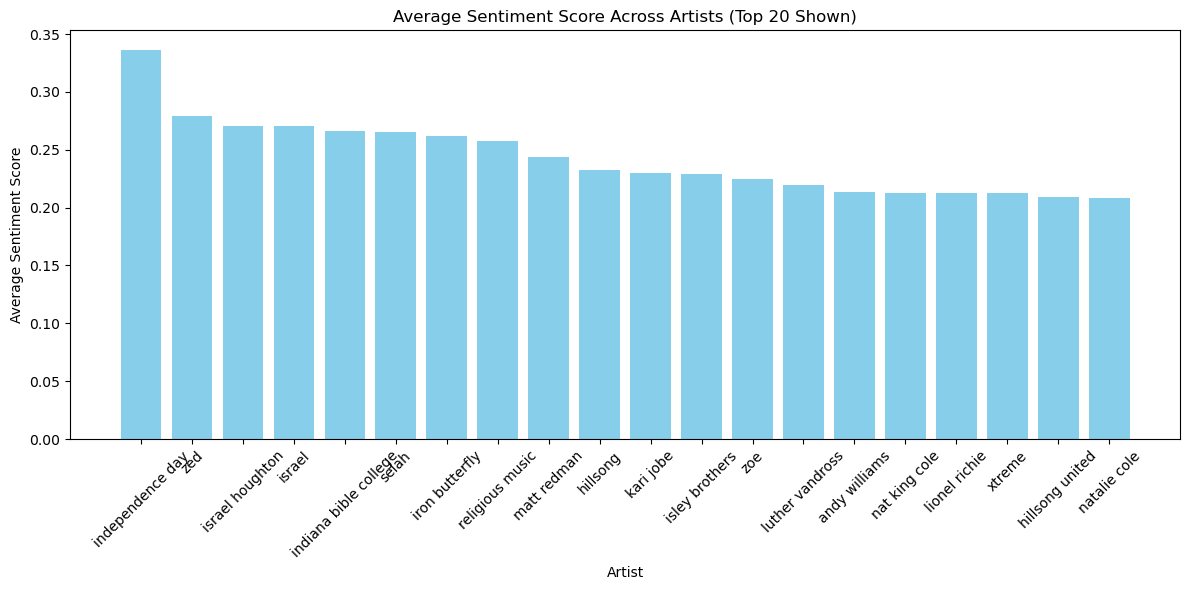

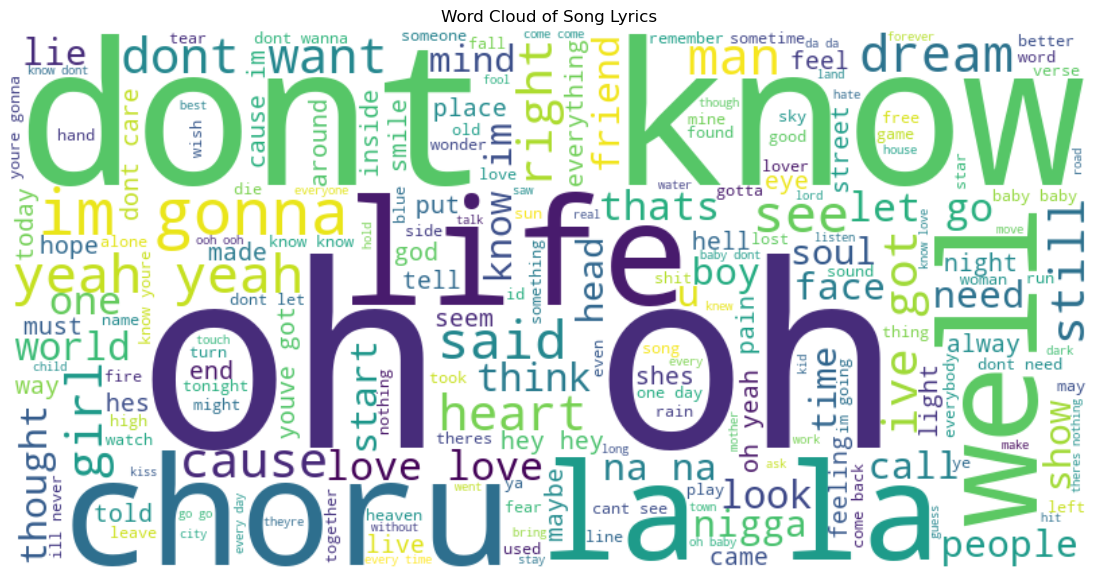

In [ ]:
# --- STEP 5: Sentiment Visualization ---
# Visualize sentiment by grouping on 'genre' if available; else 'artist'
# (Note: the fuzzy merge may put genre information in a column named 'Genre')
if "Genre" in df.columns:
    grouping_column = "Genre"
    title_text = "Average Sentiment Score Across Music Genres"
elif "artist" in df.columns:
    grouping_column = "artist"
    title_text = "Average Sentiment Score Across Artists (Top 20 Shown)"
else:
    grouping_column = None

if grouping_column:
    group_sentiment = df.groupby(grouping_column)["sentiment_score"].mean().reset_index()
    if grouping_column == "artist" and len(group_sentiment) > 20:
        group_sentiment = group_sentiment.sort_values(by="sentiment_score", ascending=False).head(20)
    
    plt.figure(figsize=(12, 6))
    plt.bar(group_sentiment[grouping_column], group_sentiment["sentiment_score"], color="skyblue")
    plt.xlabel(grouping_column.capitalize())
    plt.ylabel("Average Sentiment Score")
    plt.title(title_text)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(10, 6))
    plt.hist(df["sentiment_score"], bins=20, color="skyblue", edgecolor="black")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Sentiment Scores")
    plt.tight_layout()
    plt.show()

# Optional: Generate a word cloud (useful for presentation visuals)
all_text = " ".join(df["clean_text"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Song Lyrics")
wordcloud_output_path = os.path.join("resources", "wordcloud.png")
plt.savefig(wordcloud_output_path)
plt.show()

In [ ]:
# --- STEP 6: Sentiment Prediction Using Machine Learning ---
# Create a binary sentiment label: 1 = positive/neutral, 0 = negative
df["sentiment_label"] = df["sentiment_score"].apply(lambda x: 1 if x >= 0 else 0)

# Extract text features from the cleaned lyrics using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df["clean_text"])
y = df["sentiment_label"]

# Split data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression classifier on the training data
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model performance on the test set
y_pred = model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on test set: 0.8902862098872506
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.77      3169
           1       0.89      0.97      0.93      8361

    accuracy                           0.89     11530
   macro avg       0.89      0.82      0.85     11530
weighted avg       0.89      0.89      0.88     11530

Confusion Matrix:
 [[2140 1029]
 [ 236 8125]]


In [16]:
# --- STEP 7: Close Database Connection ---
conn.close()
print("SQL connection closed.")

SQL connection closed.


Merged dataset loaded with shape: (57650, 9)
'sentiment_score' column not found. Computing sentiment_score from 'text' column...


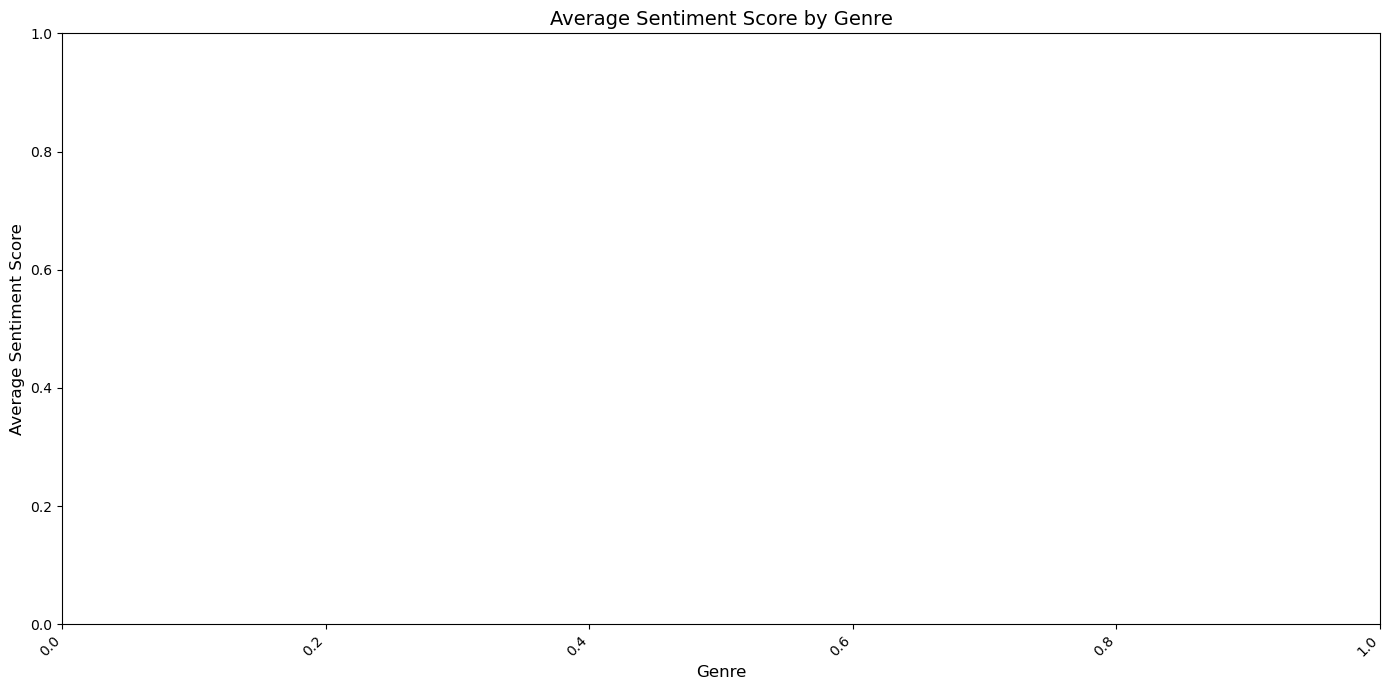

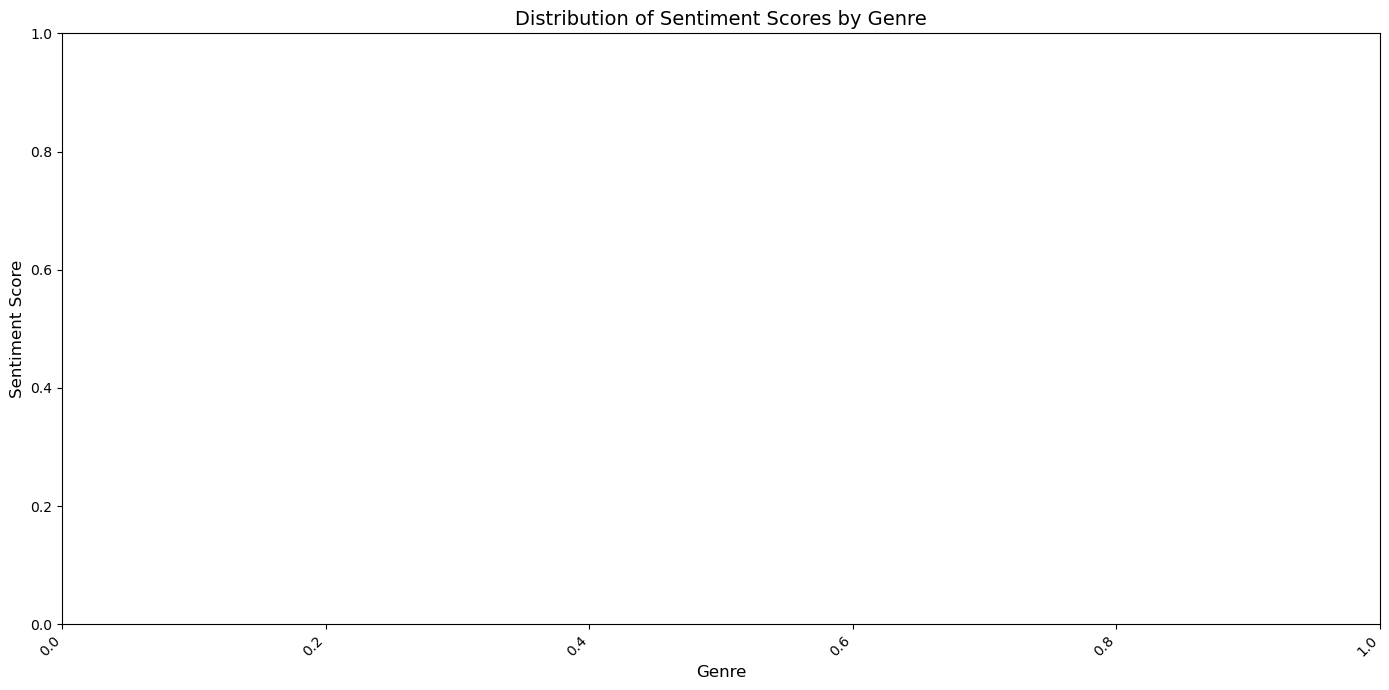

C:\Users\olive\AppData\Local\Temp\ipykernel_28704\382576260.py:64: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="Popularity", y="sentiment_score", hue="Genre", data=df,
C:\Users\olive\AppData\Local\Temp\ipykernel_28704\382576260.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


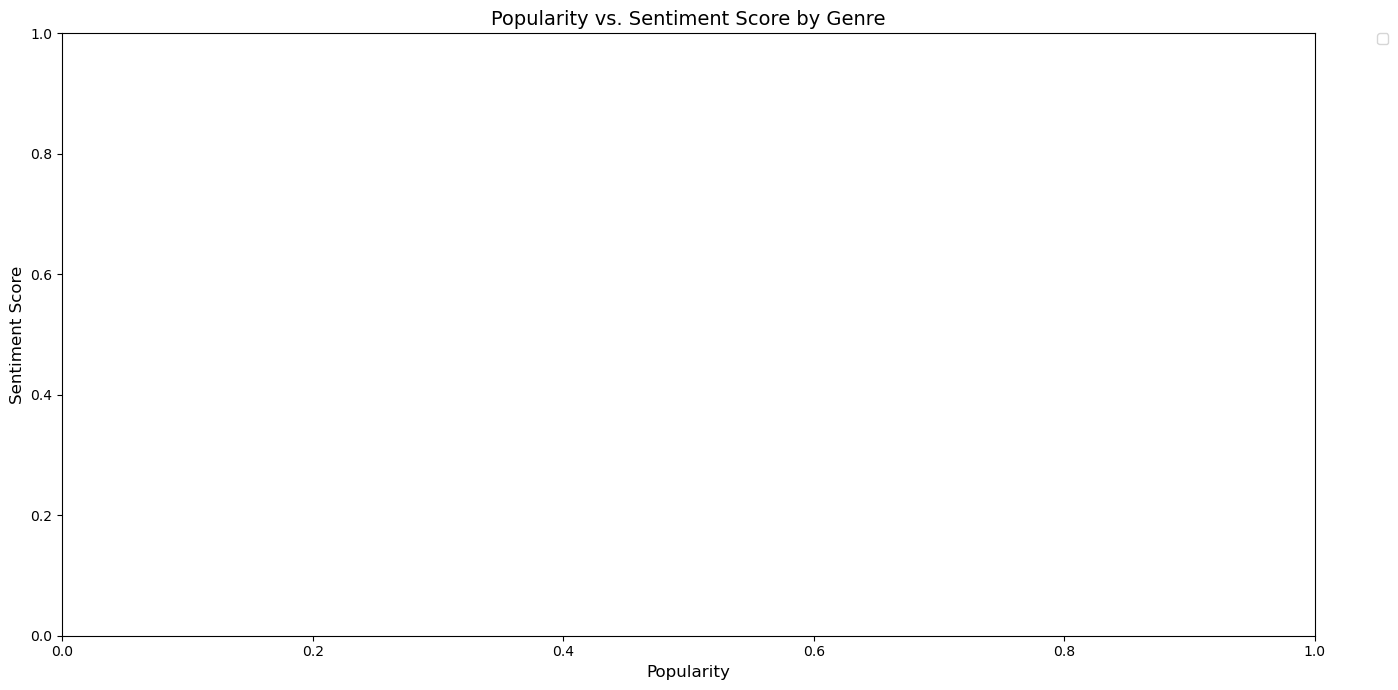

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# --- STEP 1: Load the Merged Dataset ---
merged_csv_path = "resources/merged_spotify_songs2000_backup.csv"
df = pd.read_csv(merged_csv_path)
print("Merged dataset loaded with shape:", df.shape)

# --- STEP 2: Clean the Genre Column ---
if 'Genre' in df.columns:
    # Keep only rows with a non-null Genre
    df = df[df['Genre'].notna()]
    # Convert Genre values to strings and strip extra whitespace
    df['Genre'] = df['Genre'].astype(str).str.strip()
    # Optionally remove rows where Genre is empty after stripping
    df = df[df['Genre'].str.len() > 0]
else:
    print("Warning: 'Genre' column not found in dataset.")

# --- STEP 3: Ensure 'sentiment_score' Column Exists ---
# If 'sentiment_score' is missing then compute it from the 'text' column using TextBlob.
if 'sentiment_score' not in df.columns:
    if 'text' in df.columns:
        print("'sentiment_score' column not found. Computing sentiment_score from 'text' column...")
        df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    else:
        raise KeyError("Neither 'sentiment_score' nor 'text' column found in the dataset.")

# Ensure that sentiment_score can be handled as numeric
df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')

# --- Visualization 1: Bar Chart - Average Sentiment Score by Genre ---
# Group the data by Genre and compute the average sentiment score
genre_stats = df.groupby("Genre")["sentiment_score"].mean().reset_index()
genre_stats = genre_stats.sort_values("sentiment_score", ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(x="Genre", y="sentiment_score", data=genre_stats, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Average Sentiment Score", fontsize=12)
plt.title("Average Sentiment Score by Genre", fontsize=14)
plt.tight_layout()
plt.show()

# --- Visualization 2: Box Plot - Distribution of Sentiment Scores by Genre ---
plt.figure(figsize=(14, 7))
sns.boxplot(x="Genre", y="sentiment_score", data=df, palette="Set3")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)
plt.title("Distribution of Sentiment Scores by Genre", fontsize=14)
plt.tight_layout()
plt.show()

# --- Visualization 3: Scatter Plot - Popularity vs. Sentiment Score, Colored by Genre ---
if "Popularity" in df.columns:
    # Convert Popularity to numeric, if necessary
    df["Popularity"] = pd.to_numeric(df["Popularity"], errors="coerce")
    
    plt.figure(figsize=(14, 7))
    sns.scatterplot(x="Popularity", y="sentiment_score", hue="Genre", data=df,
                    palette="deep", alpha=0.7)
    plt.xlabel("Popularity", fontsize=12)
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.title("Popularity vs. Sentiment Score by Genre", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()
else:
    print("Popularity column not found in the dataset. Skipping scatter plot.")
